In [74]:
import os
import sys

sys.path.append(f"{os.getcwd()}/../")

In [199]:
import time
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from joblib import dump, load

from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import VotingClassifier
# from gensim.models import Word2Vec

from processing.utils import CleanUp, SNOWBALL_STEMMER

%matplotlib inline

clean_up = CleanUp(stemmer=SNOWBALL_STEMMER)

In [76]:
corpus = []

filename = f"{os.getcwd()}/../../data/embedding/corpus.txt"
file_it = pd.read_csv(filename, header=None, iterator=True, names=["sentence"], chunksize=10000,)

# i = 0
for lines in file_it:
#     if i == 2:
#         break
    for line in lines["sentence"].tolist():
        corpus.append(clean_up.fit(line))
#     i += 1

In [203]:
df = pd.read_csv(f"{os.getcwd()}/../../data/dataset.csv", sep="|")
df["x"] = df["comentario"].apply(lambda comment: clean_up.fit(str(comment)))
df["y"] = df["classificacao"].apply(lambda clasf: 0 if clasf == "negativo" else 1)
textos = df[["x", "y"]].to_numpy()

In [204]:
print(random.choice(textos))
print(len(textos))
# print(df[df['x'] == ''].index)
# print(df.loc[250])

['nao sei esestouu com coron virus rinit ataqu panic ansiedad com saudad jonathan'
 0]
2197


In [171]:
# class Word2VecVectorizer(TransformerMixin, BaseEstimator):
    
#     def __init__(self):
#         self.w2v = Word2Vec.load(f"{os.getcwd()}/../ai/models/w2v.model")
#         # print(f"Palavras no vocab: {len(list(self.w2v.wv.vocab))}")
    
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X):
#         n_textos = []
#         for texto in X:
#             doc = []
#             for palavra in texto.split():
#                 try:
#                     doc.append(self.w2v.wv[palavra])
#                 except:
#                     doc.append(np.zeros(300, ))
#             n_textos.append(np.mean(doc, axis=0))
#         return StandardScaler().fit_transform(np.asarray(n_textos)) 
    
#     def fit_transform(self, X, y=None):
#         return self.transform(X)

In [172]:
# w2v = Word2VecVectorizer()
# sgd_w2v = SGDClassifier(
#     alpha=1e-7,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=3000,
#     n_iter_no_change=50
# )

# pipe = make_pipeline(w2v, sgd_w2v)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# pipe.fit(X_train, y_train)
# pred = pipe.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [205]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), lowercase=False).fit(corpus)

In [212]:
# clf = SGDClassifier(
#     alpha=1e-5,
#     random_state=0,
#     n_jobs=-1,
#     max_iter=5000,
#     n_iter_no_change=100
# )
clf = SVC(kernel="linear", C=5, random_state=0)

              precision    recall  f1-score   support

           0       0.84      0.74      0.79       270
           1       0.66      0.78      0.71       170

    accuracy                           0.76       440
   macro avg       0.75      0.76      0.75       440
weighted avg       0.77      0.76      0.76       440



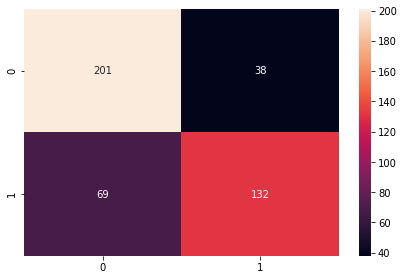

In [213]:
pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

print(classification_report(y_test, pred))

df_cm = confusion_matrix(pred, y_test)
plt.figure(figsize=(6, 4))
sn.heatmap(df_cm, annot=True, fmt="d")
plt.tight_layout()
plt.show()

In [214]:
# params = {
#     'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#     'alpha': [1e-1, 1e-3, 1e-5, 1e-7],
#     'max_iter': [500, 1000, 2000, 3000],
#     'n_iter_no_change': [10, 25, 50]
# }

# clf = make_pipeline(tfidf, 
#                     GridSearchCV(SGDClassifier(random_state=0, n_jobs=-1,),
#                                  params,
#                                  cv=5,
#                                  refit=True, n_jobs=-1))

# params = {
#     'kernel': ['linear', 'rbf', 'sigmoid'],
#     'C': [0.1, 0.5, 1, 5, 10],
#     'tol': [1e-1, 1e-2, 1e-3, 1e-4],
#     'decision_function_shape': ['ovo', 'ovr']
# }

# cv = GridSearchCV(SVC(random_state=0), params, refit=True, n_jobs=-1)
# clf = make_pipeline(tfidf, cv)

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# clf.fit(X_train, y_train)
# pred = clf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [215]:
# clf1 = make_pipeline(w2v, sgd_w2v)
# clf2 = make_pipeline(tfidf, sgd_tfidf)

# eclf = VotingClassifier(
#     estimators=[('w2v', clf1), ('tfidf', clf2)],
#     voting='hard', weights=[1, 1], n_jobs=-1
# )

# X = textos[:, 0]
# y = textos[:, 1].astype(np.int).ravel()

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# eclf.fit(X_train, y_train)
# pred = eclf.predict(X_test)

# print(classification_report(y_test, pred))

# df_cm = confusion_matrix(pred, y_test)
# plt.figure(figsize=(6, 4))
# sn.heatmap(df_cm, annot=True, fmt="d")
# plt.tight_layout()
# plt.show()

In [217]:
pipe = make_pipeline(tfidf, clf)

X = textos[:, 0]
y = textos[:, 1].astype(np.int).ravel()

pipe.fit(X, y)

dump(pipe, f"{os.getcwd()}/../ai/models/tweets_classifier.model")

['/ssd/programas/Covid19-Twitter-Tracker/code/src/notebook/../ai/models/tweets_classifier.model']